In [1]:
#Installations
import os

# Install pyspark & spark-nlp
! pip install spark-nlp==4.2.4 pyspark==3.2.1

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install geopy
!pip install geopy

# Install geopandas
!pip install --upgrade geopandas
!pip install geoplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 25.4 MB/s 
     |████████████████████████████████| 281.4 MB 42 kB/s 
     |████████████████████████████████| 198 kB 72.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853643 sha256=c2ac1f09cb6c15cdbd15ab3606be068337df8e2212f811c859cbd9be63c37796
  Stored in directory: /root/.cache/pip/wheels/58/94/83/915c9059e4b038e2d43a6058f307fe1c3e8536e5745f3b23b7
Successfully built pyspark
openjdk version "1.8.0_352"
OpenJDK Runtime Environment (build 1.8.0_352-8u352-ga-1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.352-b08, mixed mode)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 27.5 MB/s 
     |████████████████████

In [2]:
# Connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Imports

import pyspark.sql.functions as F

import sparknlp

from sparknlp.annotator import Tokenizer
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sparknlp.annotator import StopWordsCleaner
from sparknlp.annotator import NGramGenerator
from sparknlp.annotator import PerceptronModel
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql import types as T

import geopy
from geopy.geocoders import Nominatim

import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Get data from drive & unzip
!unzip /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip

Archive:  /content/gdrive/Shareddrives/ukraine-russia/ukraine-russia.zip
   creating: ukraine-russia/
  inflating: ukraine-russia/08.csv   
  inflating: __MACOSX/ukraine-russia/._08.csv  
  inflating: ukraine-russia/09.csv   
  inflating: __MACOSX/ukraine-russia/._09.csv  
  inflating: ukraine-russia/02.csv   
  inflating: __MACOSX/ukraine-russia/._02.csv  
  inflating: ukraine-russia/03.csv   
  inflating: __MACOSX/ukraine-russia/._03.csv  
  inflating: ukraine-russia/04.csv   
  inflating: __MACOSX/ukraine-russia/._04.csv  
  inflating: ukraine-russia/10.csv   
  inflating: __MACOSX/ukraine-russia/._10.csv  
  inflating: ukraine-russia/05.csv   
  inflating: __MACOSX/ukraine-russia/._05.csv  
  inflating: ukraine-russia/07.csv   
  inflating: __MACOSX/ukraine-russia/._07.csv  
  inflating: ukraine-russia/06.csv   
  inflating: __MACOSX/ukraine-russia/._06.csv  


In [5]:
# Start spark
spark = sparknlp.start()

In [6]:
# Load Data
df = spark.read.csv("./ukraine-russia/10.csv", header=True,  inferSchema=True)
df = df.filter(F.col("language")=="en")

In [7]:
#Show df
df.show()

# Count rows
df.count()

+----------+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+-------------------+-------------------+-------------------+------------+--------------------+--------------------+--------+-----------+--------------+----------+-----------------+---------------------+-----------------------+---------------------+-------------------+-----------------------+---------------+-------------------+--------------------+----------------------+--------------------+
|Unnamed: 0|             userid|       username|            acctdesc|            location|following|followers|totaltweets|      usercreatedts|            tweetid|     tweetcreatedts|retweetcount|                text|            hashtags|language|coordinates|favorite_count|is_retweet|original_tweet_id|original_tweet_userid|original_tweet_username|in_reply_to_status_id|in_reply_to_user_id|in_reply_to_screen_name|is_quote_status|   quoted_status_id|quoted_status_userid|quoted_status

59224

In [8]:
# Parse df and select required columns
df1 = (df.select('language', 'location', 'text',)
        .where(F.col('language').isNotNull())
        .where(F.col('location').isNotNull())
        .where(F.length(F.col('language')) < 3)
        .where(F.length(F.col('language')) > 1))
df1.show()
df1.count()

+--------+--------------------+--------------------+
|language|            location|                text|
+--------+--------------------+--------------------+
|      en|Edinburgh ~ Heart...|Where are #ATACMS...|
|      en|Guernsey (UK Chan...|You don't have to...|
|      en|              Sydney|If🇺🇦  is winnin...|
|      en|              Canada|@PerrierB1 @nafof...|
|      en|              CANADA|@60Minutes oh Gaw...|
|      en|Virginia, United ...|Putin Underestima...|
|      en|New York, Catalun...|The only truth co...|
|      en|Northern Ontario,...|@irmachep Being h...|
|      en|            New York|Gutted. The @60Mi...|
|      en|     State of Auburn|#Russia governmen...|
|      en|            America |I got one word fo...|
|      en|            Portugal|The Big Short Liv...|
|      en|       United States|Give the people @...|
|      en|     Florida Straits|Putin is truly ev...|
|      en|         Orlando, FL|Now playing Can't...|
|      en| North Carolina, USA|If that @60Minute

40101

In [9]:
# Preprocess Text
def preprocess_data(indf):
  indf = indf.filter(indf.text.isNotNull())
  #tweet_col = ('location','text')
  review_text = indf.select("location","text").filter(F.col("location").isNotNull())
  clean = review_text.withColumn('text', F.regexp_replace('text', r"http\S+", ''))
  clean = clean.withColumn('text', F.regexp_replace('text', r"\w+followback\w+", ''))
  clean = clean.withColumn('text', F.regexp_replace('text', '#', ''))
  clean = clean.withColumn('text', F.regexp_replace('text', 'RT', ''))
  clean_text = clean.withColumn('text', F.regexp_replace('text', ':', ''))
  return clean_text

df1 = preprocess_data(df1)
df1.show()
df1.count()

+--------------------+--------------------+
|            location|                text|
+--------------------+--------------------+
|Edinburgh ~ Heart...|Where are ATACMS ...|
|Guernsey (UK Chan...|You don't have to...|
|              Sydney|If🇺🇦  is winnin...|
|              Canada|@PerrierB1 @nafof...|
|              CANADA|@60Minutes oh Gaw...|
|Virginia, United ...|Putin Underestima...|
|New York, Catalun...|The only truth co...|
|Northern Ontario,...|@irmachep Being h...|
|            New York|Gutted. The @60Mi...|
|     State of Auburn|Russia government...|
|            America |I got one word fo...|
|            Portugal|The Big Short Liv...|
|       United States|Give the people @...|
|     Florida Straits|Putin is truly ev...|
|         Orlando, FL|Now playing Can't...|
| North Carolina, USA|If that @60Minute...|
|       Oklahoma, USA|I am outraged wat...|
|              Canada|@PerrierB1 @Geras...|
|    Calgary, Alberta|‘It’s driven by f...|
|Guernsey (UK Chan...|You don't ha

40101

In [10]:
# Take Sample of 5000
df2 = df1.limit(5000)
df2.show()
df2.count()

+--------------------+--------------------+
|            location|                text|
+--------------------+--------------------+
|Edinburgh ~ Heart...|Where are ATACMS ...|
|Guernsey (UK Chan...|You don't have to...|
|              Sydney|If🇺🇦  is winnin...|
|              Canada|@PerrierB1 @nafof...|
|              CANADA|@60Minutes oh Gaw...|
|Virginia, United ...|Putin Underestima...|
|New York, Catalun...|The only truth co...|
|Northern Ontario,...|@irmachep Being h...|
|            New York|Gutted. The @60Mi...|
|     State of Auburn|Russia government...|
|            America |I got one word fo...|
|            Portugal|The Big Short Liv...|
|       United States|Give the people @...|
|     Florida Straits|Putin is truly ev...|
|         Orlando, FL|Now playing Can't...|
| North Carolina, USA|If that @60Minute...|
|       Oklahoma, USA|I am outraged wat...|
|              Canada|@PerrierB1 @Geras...|
|    Calgary, Alberta|‘It’s driven by f...|
|Guernsey (UK Chan...|You don't ha

5000

In [11]:
# Sentiment
def getNegSentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  score = analyzer.polarity_scores(text)

  return score['neg']

def getPosSentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  score = analyzer.polarity_scores(text)

  return score['pos']

def getNeuSentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  score = analyzer.polarity_scores(text)

  return score['neu']

udfNegSentimentScore = F.udf(getNegSentiment, T.FloatType())
udfPosSentimentScore = F.udf(getPosSentiment, T.FloatType())
udfNeuSentimentScore = F.udf(getNeuSentiment, T.FloatType())

df3 = df2.withColumn("posSentiment", udfPosSentimentScore("text"))\
.withColumn("negSentiment", udfNegSentimentScore("text"))\
.withColumn("neuSentiment", udfNeuSentimentScore("text"))

df3.show()
df3.count()

+--------------------+--------------------+------------+------------+------------+
|            location|                text|posSentiment|negSentiment|neuSentiment|
+--------------------+--------------------+------------+------------+------------+
|Edinburgh ~ Heart...|Where are ATACMS ...|         0.0|         0.0|         1.0|
|Guernsey (UK Chan...|You don't have to...|       0.133|       0.128|       0.739|
|              Sydney|If🇺🇦  is winnin...|       0.177|       0.146|       0.677|
|              Canada|@PerrierB1 @nafof...|       0.205|       0.328|       0.467|
|              CANADA|@60Minutes oh Gaw...|         0.0|       0.266|       0.734|
|Virginia, United ...|Putin Underestima...|         0.0|       0.139|       0.861|
|New York, Catalun...|The only truth co...|       0.162|       0.213|       0.625|
|Northern Ontario,...|@irmachep Being h...|        0.09|       0.218|       0.692|
|            New York|Gutted. The @60Mi...|         0.0|         0.0|         1.0|
|     

5000

In [12]:
#define geoLocation
geolocator = Nominatim(timeout=10, user_agent = "my-application")

In [ ]:
# Add Latitude & Longitude columns
def getLatitude(locationName):
  location = geolocator.geocode(locationName)
  if location is None:
    return None
  else:
      return location.latitude

def getLongitude(locationName):
  location = geolocator.geocode(locationName)
  if location is None:
    return None
  else:
      return location.longitude

udfLatitude = F.udf(getLatitude, T.StringType())
udfLongitude = F.udf(getLongitude, T.StringType())

df4 = df3.withColumn("latitude", udfLatitude("location")).withColumn("longitude", udfLongitude("location")).filter((F.col("latitude").isNotNull()) | (F.col("longitude").isNotNull()))
df4.show(10)

In [16]:
# Filter nulls out
df5 = df4.filter((F.col("latitude").isNotNull()) | (F.col("longitude").isNotNull()))
df5.count()

PythonException: ignored

In [21]:
#Save to csv
df5.write.options(header='True', delimiter=',').csv("./geoLocation.csv")

Py4JJavaError: ignored

In [ ]:
# Read from exported csv
df6 = spark.read.csv("./geoLocation.csv", header=True,  inferSchema=True)
df6.show()
df6.count()

+--------------------+--------------------+------------+------------+------------+------------------+----------------+
|            location|                text|posSentiment|negSentiment|neuSentiment|          latitude|       longitude|
+--------------------+--------------------+------------+------------+------------+------------------+----------------+
|                  UK|12/08/2022 StandW...|         0.0|         0.0|         1.0|        54.7023545|      -3.2765753|
|                 usa|biden is lower th...|         0.0|       0.306|       0.694|        39.7837304|     -100.445882|
|        Tokyo, Japan|Visiting peace mu...|       0.229|       0.137|       0.634|        35.6828387|     139.7594549|
|     The White House|Kayleigh McEnany'...|         0.0|         0.0|         1.0|38.897699700000004|    -77.03655315|
|        planet earth|@NotAbouThatBase ...|       0.071|       0.139|        0.79|        14.3601126|     100.5772104|
|        Planet Earth|SlavaUkraini Stay...|     

837

In [ ]:
# PySpark DF to pandas DF
pandas_df = df6.toPandas()
pandas_df

,location,text,posSentiment,negSentiment,neuSentiment,latitude,longitude
0,UK,12/08/2022 StandWithUkraine Ukraine DigitalRes...,0.000,0.000,1.000,54.702354,-3.276575
1,usa,biden is lower then a crook roach,0.000,0.306,0.694,39.783730,-100.445882
2,"Tokyo, Japan","Visiting peace museums, talking to survivors o...",0.229,0.137,0.634,35.682839,139.759455
3,The White House,Kayleigh McEnany's sister launches conservativ...,0.000,0.000,1.000,38.897700,-77.036553
4,planet earth,@NotAbouThatBase its horrifying ... but the UN...,0.071,0.139,0.790,14.360113,100.577210
...,...,...,...,...,...,...,...
832,Boston,@BballcoachNY i think he is trying to rally wi...,0.111,0.056,0.833,42.355433,-71.060511
833,Hong Kong,"'Charm offensives minus the charm are just, we...",0.269,0.105,0.626,22.279328,114.162813
834,"Washington, DC",@JesseKellyDC @KatrinaPierson Every single FBI...,0.332,0.097,0.571,38.895037,-77.036543
835,"Washington, DC",@dangainor You’re giving Trump too much credit...,0.112,0.181,0.707,38.895037,-77.036543


In [ ]:
# Add column with Points as Geometry from lat & long
gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df.longitude, pandas_df.latitude))
print(gdf.head())

          location                                               text  \
0               UK  12/08/2022 StandWithUkraine Ukraine DigitalRes...   
1              usa                  biden is lower then a crook roach   
2     Tokyo, Japan  Visiting peace museums, talking to survivors o...   
3  The White House  Kayleigh McEnany's sister launches conservativ...   
4     planet earth  @NotAbouThatBase its horrifying ... but the UN...   

   posSentiment  negSentiment  neuSentiment   latitude   longitude  \
0         0.000         0.000         1.000  54.702354   -3.276575   
1         0.000         0.306         0.694  39.783730 -100.445882   
2         0.229         0.137         0.634  35.682839  139.759455   
3         0.000         0.000         1.000  38.897700  -77.036553   
4         0.071         0.139         0.790  14.360113  100.577210   

                      geometry  
0    POINT (-3.27658 54.70235)  
1  POINT (-100.44588 39.78373)  
2   POINT (139.75945 35.68284)  
3   POIN

In [ ]:
gdf

,location,text,posSentiment,negSentiment,neuSentiment,latitude,longitude,geometry
0,UK,12/08/2022 StandWithUkraine Ukraine DigitalRes...,0.000,0.000,1.000,54.702354,-3.276575,POINT (-3.27658 54.70235)
1,usa,biden is lower then a crook roach,0.000,0.306,0.694,39.783730,-100.445882,POINT (-100.44588 39.78373)
2,"Tokyo, Japan","Visiting peace museums, talking to survivors o...",0.229,0.137,0.634,35.682839,139.759455,POINT (139.75945 35.68284)
3,The White House,Kayleigh McEnany's sister launches conservativ...,0.000,0.000,1.000,38.897700,-77.036553,POINT (-77.03655 38.89770)
4,planet earth,@NotAbouThatBase its horrifying ... but the UN...,0.071,0.139,0.790,14.360113,100.577210,POINT (100.57721 14.36011)
...,...,...,...,...,...,...,...,...
832,Boston,@BballcoachNY i think he is trying to rally wi...,0.111,0.056,0.833,42.355433,-71.060511,POINT (-71.06051 42.35543)
833,Hong Kong,"'Charm offensives minus the charm are just, we...",0.269,0.105,0.626,22.279328,114.162813,POINT (114.16281 22.27933)
834,"Washington, DC",@JesseKellyDC @KatrinaPierson Every single FBI...,0.332,0.097,0.571,38.895037,-77.036543,POINT (-77.03654 38.89504)
835,"Washington, DC",@dangainor You’re giving Trump too much credit...,0.112,0.181,0.707,38.895037,-77.036543,POINT (-77.03654 38.89504)


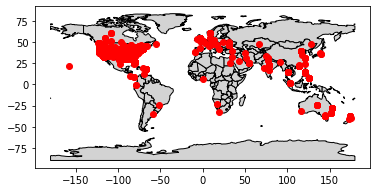

In [ ]:
# Plot locations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world = world[(world.pop_est>0) & (world.name!="Antarctica")]

ax = world.plot(color='lightgrey', edgecolor='black')
gdf.crs = 'epsg:3395'
gdf.plot(ax=ax, color='red')

plt.show()

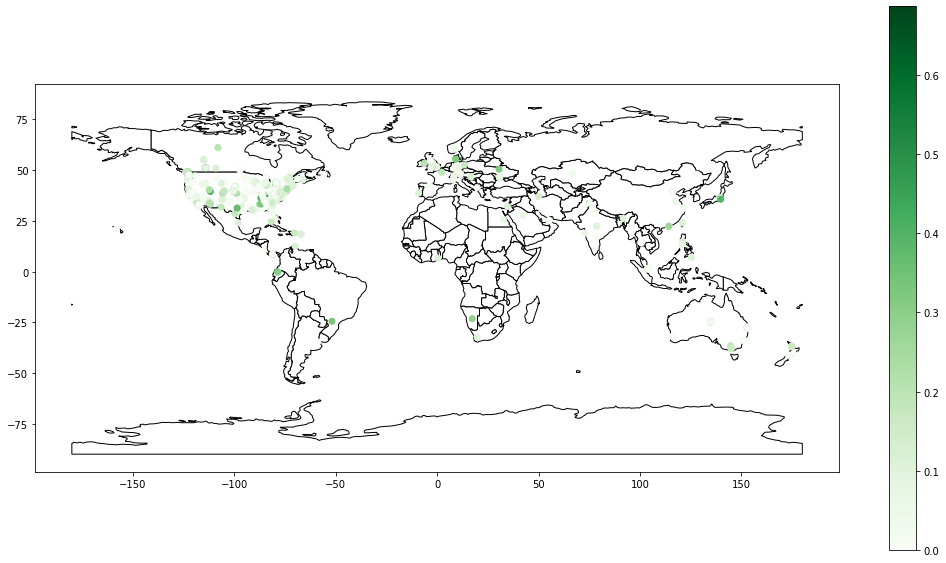

In [ ]:
#import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [18, 10]

ax = world.plot(color='white', edgecolor='black')
gdf.plot(column='posSentiment', ax=ax, legend=True, cmap='Greens')

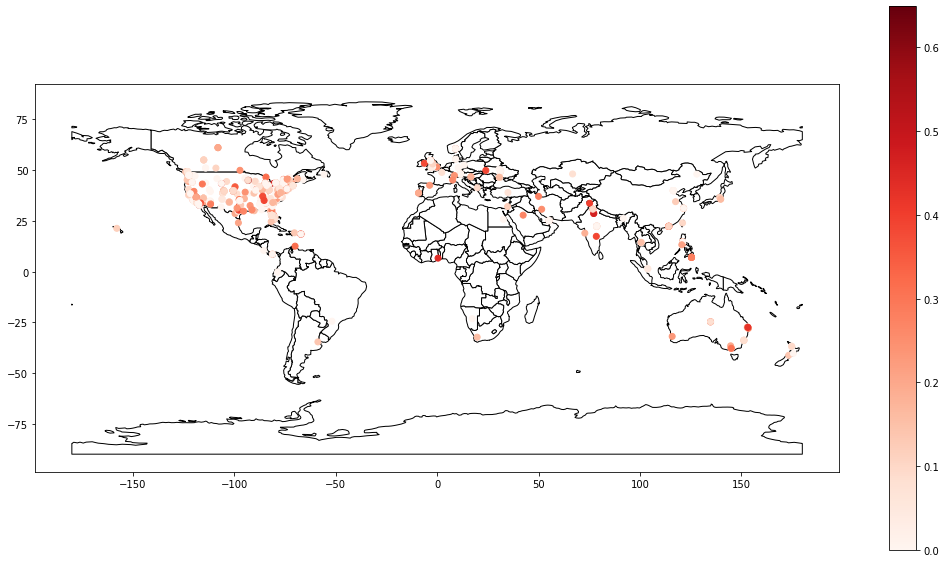

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [18, 10]

ax = world.plot(color='white', edgecolor='black')
gdf.plot(column='negSentiment', ax=ax, legend=True, cmap='Reds')

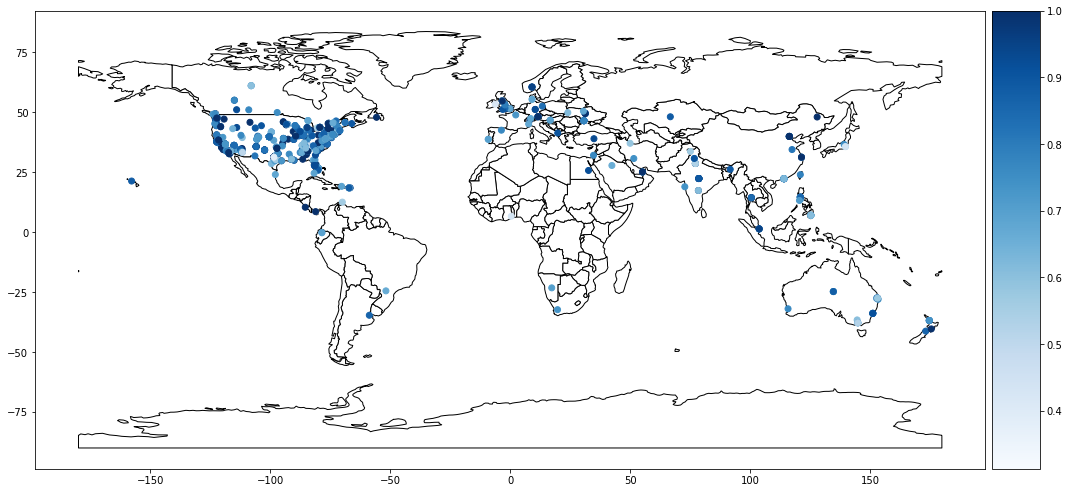

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
plt.rcParams["figure.figsize"] = [18, 10]

ax = world.plot(color='white', edgecolor='black')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(column='neuSentiment', ax=ax, legend=True, figsize=(18,18), cax=cax, cmap='Blues')#, scheme='quantiles')

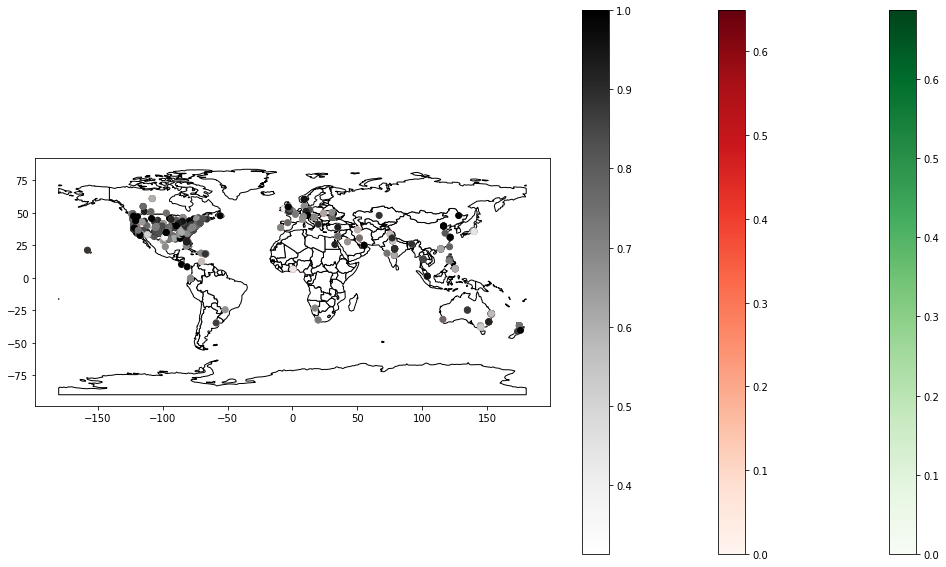

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [18, 10]

ax = world.plot(color='white', edgecolor='black')
gdf.plot(column='posSentiment', ax=ax, legend=True, cmap='Greens')
gdf.plot(column='negSentiment', ax=ax, legend=True, cmap='Reds')
gdf.plot(column='neuSentiment', ax=ax, legend=True, cmap='Greys')